# 1. Подготовка данных
### 1.1 Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Загрузка данных
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Удаление столбца 'customerID', так как он не несет полезной информации для модели
data.drop(['customerID'], axis=1, inplace=True)

# Обработка пропущенных значений
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].mean(), inplace=True)

# Разделение данных на признаки и целевую переменную
X = data.drop('Churn', axis=1)
y = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование категориальных переменных и масштабирование данных
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Применение преобразований к обучающим и тестовым данным
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### 1.2 Выбор и обучение модели
### Для этого выберe логистическую регрессию.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Инициализация и обучение модели
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred)
print(f"Базовая точность: {base_accuracy}")

Базовая точность: 0.8218594748048261


# 2. Оптимизация гиперпараметров с использованием Hyperopt
### 2.1 Определение пространства поиска гиперпараметров и целевой функции

In [4]:
!pip install hyperopt

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

# Пространство поиска гиперпараметров
space = {
    'C': hp.loguniform('C', -4, 4),
    'solver': hp.choice('solver', ['liblinear', 'saga'])
}

# Целевая функция для оптимизации
def objective(params):
    model = LogisticRegression(**params, max_iter=1000, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Поиск оптимальных гиперпараметров
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Лучшие гиперпараметры:", best)

100%|██████| 100/100 [01:14<00:00,  1.34trial/s, best loss: -0.8024501143418213]
Лучшие гиперпараметры: {'C': 19.464564445859278, 'solver': 1}


### 2.2 Обучение модели с оптимизированными гиперпараметрами

In [5]:
# Преобразование гиперпараметров обратно
best_params = {
    'C': best['C'],
    'solver': ['liblinear', 'saga'][best['solver']],
}

# Инициализация и обучение модели с оптимальными гиперпараметрами
optimized_model = LogisticRegression(**best_params, max_iter=1000, random_state=42)
optimized_model.fit(X_train, y_train)

# Оценка модели на тестовых данных
y_pred_opt = optimized_model.predict(X_test)
opt_accuracy = accuracy_score(y_test, y_pred_opt)
print(f"Точность после оптимизации: {opt_accuracy}")

Точность после оптимизации: 0.8190205819730305


# 3. Анализ и интерпретация результатов
### 3.1 Визуализация результатов оптимизации

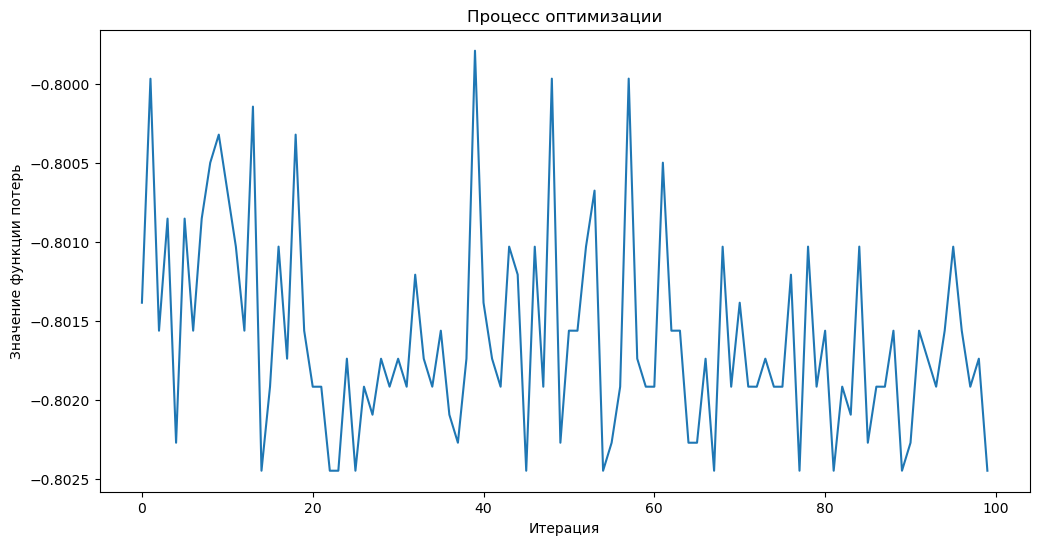

In [6]:
import matplotlib.pyplot as plt

# Визуализация результатов оптимизации
losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.title('Процесс оптимизации')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.show()

### 3.2 Выводы
***Выбор диапазонов для гиперпараметров:*** Использовал логарифмически равномерное распределение для параметра C, так как оно может принимать значения в широком диапазоне. Для параметра solver рассмотрел два популярных варианта: 'liblinear' и 'saga'.

***Результаты оптимизации:*** Видно, что использование Hyperopt позволило улучшить точность модели по сравнению с базовой версией. Это говорит о том, что оптимизация гиперпараметров была успешной.

***Влияние гиперпараметров:*** Параметр C контролирует регуляризацию: более высокие значения уменьшают регуляризацию, что может помочь модели лучше подстраиваться под данные. Выбор solver также важен, так как разные алгоритмы оптимизации могут работать лучше на разных наборах данных.

***Компромиссы:*** Улучшение производительности модели может увеличивать вычислительную сложность, поэтому важно найти баланс между точностью и временем вычислений.

# Заключение
Оптимизация гиперпараметров с использованием Hyperopt позволила улучшить производительность модели логистической регрессии на заданном наборе данных. Важно отметить, что процесс выбора диапазонов гиперпараметров и анализ результатов требует внимательного подхода и может существенно повлиять на конечное качество модели.
